In [1]:
#!pip install category_encoders

In [2]:
#imports
import os
from six.moves import urllib
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import seaborn as sns
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from statsmodels import robust

In [3]:
DOWNLOAD_ROOT = "http://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening"
CREDIT_DATA_URL = DOWNLOAD_ROOT + "/crx.data"
CREDIT_DATA_PATH = "datasets/credit-screening"

In [4]:
# fetch data from its origin
def fetch_credit_card_data(credit_data_url=CREDIT_DATA_URL, credit_path=CREDIT_DATA_PATH):
    if not os.path.isdir(credit_path):
        os.makedirs(credit_path)
    credit_data_path = os.path.join(credit_path, "crx.data")
    urllib.request.urlretrieve(credit_data_url, credit_data_path)

fetch_credit_card_data()

In [5]:
def load_credit_card_data(credit_data_path=CREDIT_DATA_PATH):
    csv_path=os.path.join(credit_data_path, "crx.data")
    pd.set_option('display.max_columns', None)
    col_names = ["Gender","Age","Debt","Married","BankCustomer","EducationLevel","Ethnicity","YearsEmployed","PriorDefault","Employed","CreditScore", "DriversLicense", "Citizen", "ZipCode", "Income" , "ApprovalStatus"]
    return pd.read_csv(csv_path, header=None, names=col_names)

dataset = load_credit_card_data()
dataframe = dataset.copy()
dataset.head(5)

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,ApprovalStatus
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [6]:
#drop columns with the lowest correlation, or columns that do not make sense
dataset = dataset.drop(['DriversLicense', 'ZipCode', 'Ethnicity', 'Gender'], axis=1)

In [7]:
#replace missing numeric values with mean
dataset = dataset.replace("?", np.nan).replace('+', 1).replace('-', 0)
dataset = dataset.astype({"Age": float})
dataset.fillna(dataset.mean(), inplace=True)
dataset.head(5)

,Age,Debt,Married,BankCustomer,EducationLevel,YearsEmployed,PriorDefault,Employed,CreditScore,Citizen,Income,ApprovalStatus
0,30.83,0.000,u,g,w,1.25,t,t,1,g,0,1
1,58.67,4.460,u,g,q,3.04,t,t,6,g,560,1
2,24.50,0.500,u,g,q,1.50,t,f,0,g,824,1
3,27.83,1.540,u,g,w,3.75,t,t,5,g,3,1
4,20.17,5.625,u,g,w,1.71,t,f,0,s,0,1


In [8]:
dataset.dtypes

Age               float64
Debt              float64
Married            object
BankCustomer       object
EducationLevel     object
YearsEmployed     float64
PriorDefault       object
Employed           object
CreditScore         int64
Citizen            object
Income              int64
ApprovalStatus      int64
dtype: object

In [9]:
#replace missing object values with the most freequent value
for col in dataset:
    if dataset[col].dtypes == 'object':
        dataset = dataset.fillna(dataset[col].value_counts().index[0])

In [10]:
dataset.dtypes

Age               float64
Debt              float64
Married            object
BankCustomer       object
EducationLevel     object
YearsEmployed     float64
PriorDefault       object
Employed           object
CreditScore         int64
Citizen            object
Income              int64
ApprovalStatus      int64
dtype: object

In [11]:
dataset.head()

,Age,Debt,Married,BankCustomer,EducationLevel,YearsEmployed,PriorDefault,Employed,CreditScore,Citizen,Income,ApprovalStatus
0,30.83,0.000,u,g,w,1.25,t,t,1,g,0,1
1,58.67,4.460,u,g,q,3.04,t,t,6,g,560,1
2,24.50,0.500,u,g,q,1.50,t,f,0,g,824,1
3,27.83,1.540,u,g,w,3.75,t,t,5,g,3,1
4,20.17,5.625,u,g,w,1.71,t,f,0,s,0,1


In [12]:
import category_encoders as ce
ohe = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True)
dataset = ohe.fit_transform(dataset)
dataset.head()

,Age,Debt,Married_u,Married_y,Married_l,BankCustomer_g,BankCustomer_p,BankCustomer_u,BankCustomer_gg,EducationLevel_w,EducationLevel_q,EducationLevel_m,EducationLevel_r,EducationLevel_cc,EducationLevel_k,EducationLevel_c,EducationLevel_d,EducationLevel_x,EducationLevel_i,EducationLevel_e,EducationLevel_aa,EducationLevel_ff,EducationLevel_j,EducationLevel_u,YearsEmployed,PriorDefault_t,PriorDefault_f,Employed_t,Employed_f,CreditScore,Citizen_g,Citizen_s,Citizen_p,Income,ApprovalStatus
0,30.83,0.000,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.25,1,0,1,0,1,1,0,0,0,1
1,58.67,4.460,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3.04,1,0,1,0,6,1,0,0,560,1
2,24.50,0.500,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.50,1,0,0,1,0,1,0,0,824,1
3,27.83,1.540,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.75,1,0,1,0,5,1,0,0,3,1
4,20.17,5.625,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.71,1,0,0,1,0,0,1,0,0,1


In [13]:
#separate the features and labels
dataset = dataset.values
X,y = dataset[:,0:34] , dataset[:,34]

In [14]:
#split the dataset into train, validation and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [15]:
#rescale the training and testing sets
#scaler = MinMaxScaler(feature_range=(0, 1))
scaler = MinMaxScaler()
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.transform(X_test)
rescaledX_val = scaler.fit_transform(X_val)

In [16]:
#instantiate the algorithms
rfc = RandomForestClassifier(random_state=42, n_estimators=100)
gnb = GaussianNB()
logreg = LogisticRegression(solver='liblinear')

In [17]:
print("Random Forrest")

roc_rfc = cross_val_score(rfc, rescaledX_train, y_train, scoring='roc_auc', cv = 5).mean()
f1_rfc = cross_val_score(rfc, rescaledX_train, y_train, scoring='f1', cv = 5).mean()
precision_rfc = cross_val_score(rfc, rescaledX_train, y_train, scoring='precision', cv = 5).mean()
rec_rfc = cross_val_score(rfc, rescaledX_train, y_train, scoring='recall', cv = 5).mean()
acc_rfc = cross_val_score(rfc, rescaledX_train, y_train, scoring='accuracy', cv = 5).mean()
y_pred_rfc = cross_val_predict(rfc, rescaledX_train, y_train, cv=5)
tn, fp, fn, tp=confusion_matrix(y_train,cross_val_predict(rfc, rescaledX_train, y_train, cv=5)).ravel()
yi_rfc = 2*roc_rfc-1
yi_rfc_formula = ((tp/(tp+fn)-(1-(tn/(fp+tn)))))

print("AUC: " , roc_rfc)
print("F1: " , f1_rfc)
print("Precission: " , precision_rfc)
print("Recall: " , rec_rfc)
print("Accuracy: " , acc_rfc)
print("Youden's index", yi_rfc)
print("Youden's index formula", yi_rfc_formula)

Random Forrest
AUC:  0.9160792123392743
F1:  0.839058160647976
Precission:  0.8275687632465851
Recall:  0.8570412517780939
Accuracy:  0.8574786023739918
Youden's index 0.8321584246785485
Youden's index formula 0.7142857142857142


In [18]:
print("Naive Bayes")
roc_gnb = cross_val_score(gnb, rescaledX_train, y_train, scoring='roc_auc', cv = 5).mean()
f1_gnb = cross_val_score(gnb, rescaledX_train, y_train, scoring='f1', cv = 5).mean()
precision_gnb = cross_val_score(gnb, rescaledX_train, y_train, scoring='precision', cv = 5).mean()
rec_gnb = cross_val_score(gnb, rescaledX_train, y_train, scoring='recall', cv = 5).mean()
acc_gnb= cross_val_score(gnb, rescaledX_train, y_train, scoring='accuracy', cv = 5).mean()

tn, fp, fn, tp = confusion_matrix(y_train,cross_val_predict(gnb, rescaledX_train, y_train, cv=5)).ravel()

yi_gnb = 2*roc_gnb-1
yi_gnb_formula = ((tp/(tp+fn)-(1-(tn/(fp+tn)))))

print("AUC of Naive Bayes is: " , roc_gnb)
print("F1: " , f1_gnb)
print("Precission: " , precision_gnb)
print("Recall: " , rec_gnb)
print("Accuracy: " , acc_gnb)
print("Youden's index", yi_gnb)
print("Youden's index formula", yi_gnb_formula)


Naive Bayes
AUC of Naive Bayes is:  0.8645021894959977
F1:  0.5047819461360978
Precission:  0.8648711390910881
Recall:  0.36443812233285916
Accuracy:  0.7029451821586653
Youden's index 0.7290043789919953
Youden's index formula 0.32142857142857145


In [19]:
print("Logistic regression")
roc_logreg = cross_val_score(logreg, rescaledX_train, y_train, scoring='roc_auc', cv = 5).mean()
f1_logreg = cross_val_score(logreg, rescaledX_train, y_train, scoring='f1', cv = 5).mean()
precision_logreg = cross_val_score(logreg, rescaledX_train, y_train, scoring='precision', cv = 5).mean()
rec_logreg = cross_val_score(logreg, rescaledX_train, y_train, scoring='recall', cv = 5).mean()
acc_logreg = cross_val_score(logreg, rescaledX_train, y_train, scoring='accuracy', cv = 5).mean()
tn, fp, fn, tp = confusion_matrix(y_train,cross_val_predict(logreg, rescaledX_train, y_train, cv=5)).ravel()
yi_logreg = 2*roc_logreg-1
yi_logreg_formula = ((tp/(tp+fn)-(1-(tn/(fp+tn)))))

print("AUC of Logistic Regression is: " , roc_logreg)
print("F1: " , f1_logreg)
print("Precission: " , precision_logreg)
print("Recall: " , rec_logreg)
print("Accuracy: " , acc_gnb)
print("Youden's index", yi_logreg)
print("Youden's index", yi_logreg_formula)

Logistic regression
AUC of Logistic Regression is:  0.9073592725852787
F1:  0.8319986513123767
Precission:  0.7995251161505491
Recall:  0.8726884779516357
Accuracy:  0.7029451821586653
Youden's index 0.8147185451705574
Youden's index 0.7023809523809524


In [20]:
param_grid = {
    'max_depth': np.linspace(1, 32, 32, endpoint=True),
    'max_features': list(range(1,rescaledX_train.shape[1])),
    'min_samples_leaf': np.linspace(0.1, 0.5, 5, endpoint=True),
    'min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True),
    'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200]
}
#grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          #cv = 5, n_jobs = -1, verbose = 2)
#grid_search.fit(rescaledX_val, y_val)

#rgs = RandomizedSearchCV(estimator=rfc, param_distributions  = param_grid, n_iter = 5000, cv = 10, n_jobs = -1, verbose = 2)
#rgs.fit(rescaledX_val, y_val)

#rgs.best_params_

In [21]:
#instantiate rfc with the best parameters
#rfc_best_model = RandomForestClassifier(max_depth=26.0,max_features=3,min_samples_leaf=0.1,min_samples_split= 0.3,n_estimators=8,random_state=42)
rfc_best_model = RandomForestClassifier(max_depth=20.0,max_features=3,min_samples_leaf=0.1,min_samples_split= 0.3,n_estimators=10,random_state=42)
#fit the train data
rfc_best_model.fit(rescaledX_train, y_train)
#predict on validation set
y_pred_val = rfc_best_model.predict(rescaledX_val)

In [22]:
tn, fp, fn, tp=confusion_matrix(y_val,y_pred_val).ravel()
yi_rfc = ((tp/(tp+fn)-(1-(tn/(fp+tn)))))
yi_rfc

0.7847402597402597

In [23]:
#print the metrics
print("AUC: " ,  metrics.roc_auc_score(y_val,y_pred_val))
print("F1: " , metrics.f1_score(y_val,y_pred_val))
print("Precission: " , metrics.precision_score(y_val,y_pred_val))
print("Recall: " ,  metrics.recall_score(y_val,y_pred_val))
print("Accuracy: " ,  metrics.accuracy_score(y_val,y_pred_val))
print("Youden's index", (2*metrics.roc_auc_score(y_val,y_pred_val)-1))

AUC:  0.8923701298701299
F1:  0.8965517241379309
Precission:  0.8524590163934426
Recall:  0.9454545454545454
Accuracy:  0.8918918918918919
Youden's index 0.7847402597402597


In [24]:
tn, fp, fn, tp = confusion_matrix(y_val,y_pred_val).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

True Negatives:  47
False Positives:  9
False Negatives:  3
True Positives:  52


Confusion matrix, without normalization
[[47  9]
 [ 3 52]]


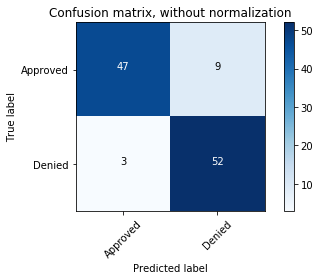

In [25]:
import itertools    

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_val, y_pred_val)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Approved','Denied'],
                      title='Confusion matrix, without normalization')


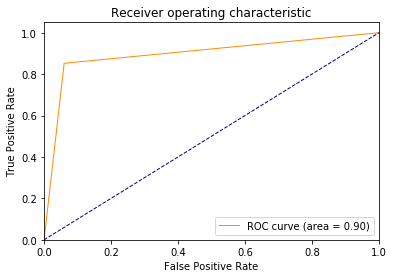

In [26]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_pred_val, y_val)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
